## Time Series Graphing Notebook

Here, we check for stationarity in the time series df, remove trends, etc.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## load in original `.csv` file

In [2]:
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')
df.head(3)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,102005556,2010-01-25T00:00:00,2010-01-22T00:00:00,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"{'latitude': '34.0454', 'needs_recoding': Fals..."
1,101822289,2010-11-11T00:00:00,2010-11-10T00:00:00,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"{'latitude': '33.9572', 'needs_recoding': Fals..."
2,101105609,2010-01-28T00:00:00,2010-01-27T00:00:00,2230,11,Northeast,1125,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,YORK,AVENUE 51,"{'latitude': '34.1211', 'needs_recoding': Fals..."


In [3]:
# cleaning time columns
df["Date Occurred"] = df["Date Occurred"].str.replace('T00:00:00', '')
df["Date Reported"] = df["Date Occurred"].str.replace('T00:00:00', '')
# # converting them to time series
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')
df['Date Reported'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')

In [4]:
# creating new df
time_df = df.groupby('Date Occurred').size().reset_index()
time_df = time_df.set_index('Date Occurred')
time_df = time_df.rename({0: 'crime_count'}, axis='columns')

In [5]:
time_df.head()

,crime_count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


## Checking for Stationarity

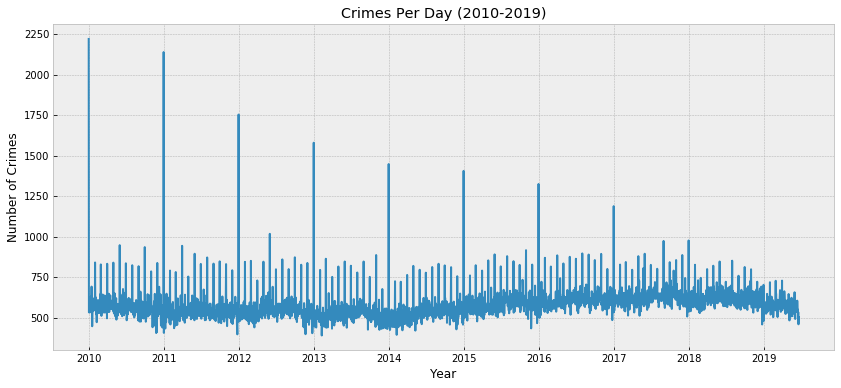

In [6]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_df['crime_count'])
plt.title('Crimes Per Day (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.savefig('visualizations/orig_time_data.png', bbox_inches = "tight", pad_inches=.5)

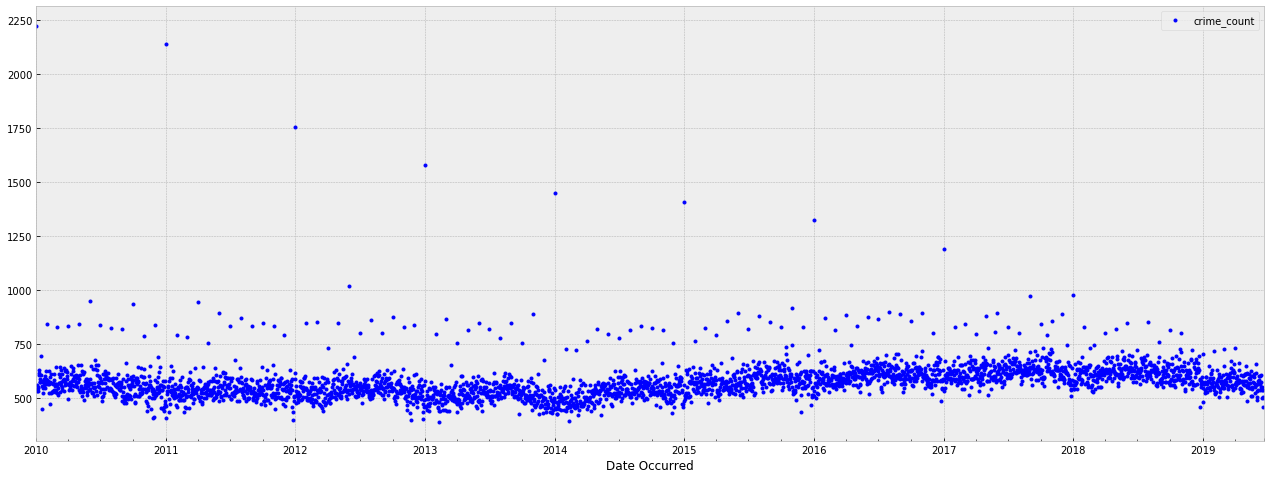

In [7]:
time_df.plot(figsize = (22,8), style = 'b.')
plt.show()

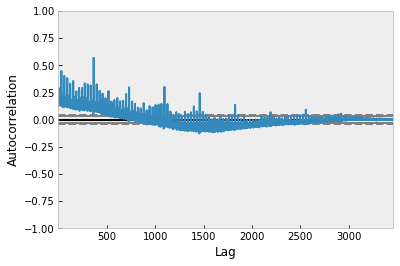

In [8]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(time_df)

## Dickey Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(time_df['crime_count'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -2.190871
p-value                           0.209576
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


we fail to reject the null because the p-value is above 0.05. this means that the original data is not stationary.

## Fixing Stationarity by Subtracting Rolling Mean

In [10]:
roll_mean = time_df.rolling(window=5, min_periods=1).mean()
roll_std = time_df.rolling(window=5, min_periods=1).std()

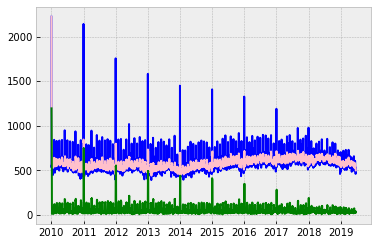

In [11]:
plt.plot(time_df['crime_count'], color = 'blue')
plt.plot(roll_mean, color = 'pink')
plt.plot(roll_std, color = 'green')

In [12]:
roll_mean.head(3)

,crime_count
Date Occurred,
2010-01-01,2222.0
2010-01-02,1377.5
2010-01-03,1098.0


In [13]:
standardized_data = time_df - roll_mean
standardized_data.head(3)

,crime_count
Date Occurred,
2010-01-01,0.0
2010-01-02,-844.5
2010-01-03,-559.0


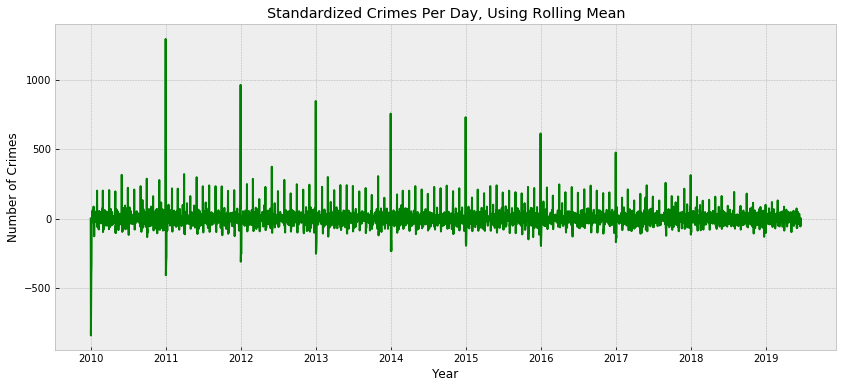

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(standardized_data['crime_count'], color='green')
plt.title('Standardized Crimes Per Day, Using Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.savefig('visualizations/minus_rolling_mean.png', bbox_inches = "tight", pad_inches=.5)

In [15]:
standardized_data.head()

,crime_count
Date Occurred,
2010-01-01,0.0
2010-01-02,-844.5
2010-01-03,-559.0
2010-01-04,-405.0
2010-01-05,-332.8


In [16]:
# dickey fuller test on new data
test = adfuller(standardized_data['crime_count'])
output = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(output)

# why is the p-value 0? it's just super small

Test Statistic                  -21.755883
p-value                           0.000000
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


## Graphing ACF & PACF of Undifferenced Data

In [17]:
# plot autocorrelation for each lag (alpha is confidence interval)
# plot_acf(standardized_data['crime_count'], alpha=.05)
# plt.show()

In [18]:
# plotting PACF
# plot_pacf(standardized_data['crime_count'], alpha=.05, lags=20)
# plt.show()

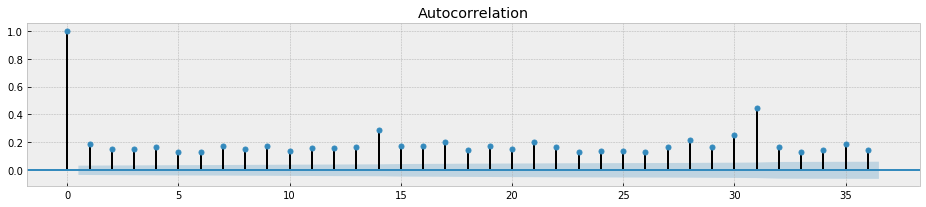

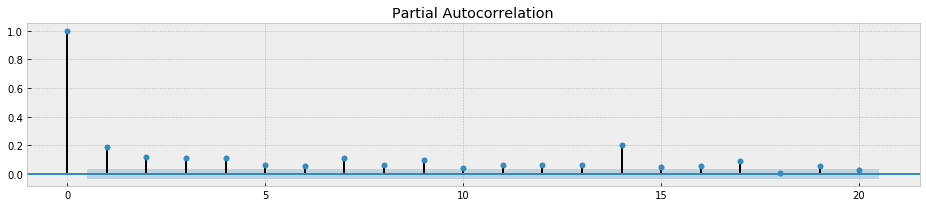

In [19]:
# graphing ACF & PACF together on 1 figure

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(time_df['crime_count'], alpha=.05, ax=ax)
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(time_df['crime_count'], alpha=.05, lags=20, ax=ax)
plt.show()

## Log Transforming the Unstationary Data

In [20]:
index = time_df.index
log_data = pd.Series(np.log(time_df['crime_count']), index=index)

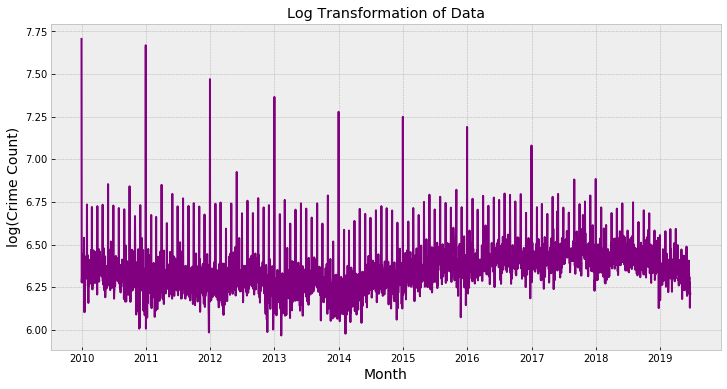

In [26]:
fig = plt.figure(figsize=(12,6))
plt.plot(log_data, color='purple')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Crime Count)', fontsize=14)
plt.title('Log Transformation of Data')

plt.savefig('visualizations/log_data.png', bbox_inches = "tight", pad_inches=.5)

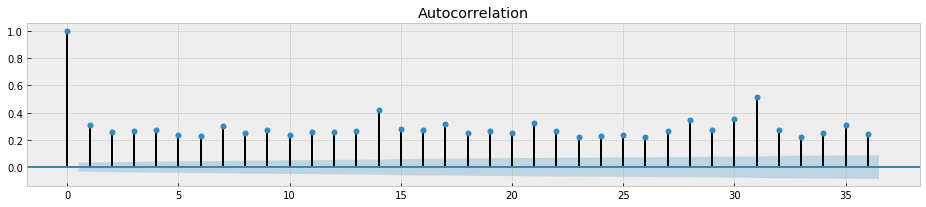

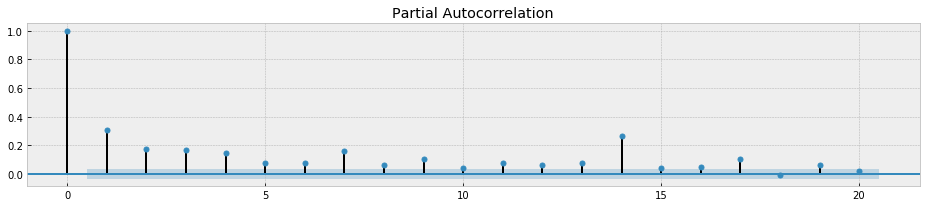

In [22]:
# ACF & PACF for Logged Data
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(log_data, alpha=.05, ax=ax)
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(log_data, alpha=.05, lags=20, ax=ax)
plt.show()

In [23]:
# converting it to a dataframe
log_data = log_data.to_frame()

In [24]:
log_data.head()

,crime_count
Date Occurred,
2010-01-01,7.706163
2010-01-02,6.278521
2010-01-03,6.289716
2010-01-04,6.324359
2010-01-05,6.304449


### For modeling process, go to `baseline.ipynb`